In [2]:
import tensorflow as tf
import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import scipy.stats as stats
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [41]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must not be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('Truth')
    plt.xlabel('Prediction')
    plt.show()


def get_frames(df, frame_size, hop_size):

    N_FEATURES = 2 # N_FEATURES = 3

    frames = []
    labels = []
    for i in range(0, len(df) - frame_size, hop_size):
        #x = df["x"].values[i: i + frame_size]  # [start seconds - start seconds + frame_size]
        y = df["y"].values[i: i + frame_size]
        z = df["z"].values[i: i + frame_size]

        # Retrieve the most frequent label in this segment
        label = df["label"].iloc[i: i + frame_size].mode()[0]  # Use .iloc for integer indexing
        frames.append([y, z]) # frames.append([x, y, z])
        labels.append(label)

    # Convert lists to NumPy arrays
    frames = np.asarray(frames).reshape(-1, frame_size, N_FEATURES)
    labels = np.asarray(labels)

    return frames, labels

def plot_learningCurve(history, epochs):
  # Plotting the accuracy graph of training & validation
  epoch_range = range(1, epochs+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Number of Epochs')
  plt.legend(['Training', 'Validation'], loc='upper right')
  plt.show()

  # Plotting the loss graph of training & validation
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Number of Epochs')
  plt.legend(['Training', 'Validation'], loc='upper right')
  plt.show()


def plot_activity(activity, data):
    fig, (axe, ax1, ax2) = plt.subplots(nrows=3, figsize=(15, 7), sharex=True)

    #plot_axis(axe, data['timestamp'], data['x'], 'X-Axis')
    plot_axis(ax1, data['timestamp'], data['y'], 'Y-Axis')

    plot_axis(ax2, data['timestamp'], data['z'], 'Z-Axis')
    plt.subplots_adjust(hspace=0.2)

    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)

    plt.show()

def plot_axis(ax, x, y, title):
    ax.plot(x,y,"r")
    ax.set_title(title)
    ax.xaxis.set_visible(False)

    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])

    ax.grid(True)

In [109]:
file = open("moj_zbior/Ultimate_no_x.txt")  # Dataset (your file path here)
lines = file.readlines()

processedData = []  # Dataset after processing, it is necessary in order to exclude incorrectly formatted data

for i, line in enumerate(lines):
    try:
        line = line.split(";")
        last = line[2].split("\n")[0] # bylo 3
        last = last.strip()
        if last == "":
            break
        temp = [line[0], line[1], last] # temp = [line[0], line[1], line[2], last]
        processedData.append(temp)
    except:
        print("Error in line: ", i)

columns = ["activity", "y", "z"] # columns = ["activity", "x", "y", "z"]
data = pd.DataFrame(data = processedData, columns = columns)

In [110]:
data.head(5) 

,activity,y,z
0,Upstairs,4.3312707,-3.7864566
1,Upstairs,3.9090397,-2.7921712
2,Upstairs,13.402422,-3.8273177
3,Upstairs,7.6273947,-3.1463003
4,Upstairs,8.921328,-3.0237172


In [111]:
data["activity"].value_counts()

activity
Walking       15438
Upstairs       2357
Sitting        2171
Downstairs     1791
Standing       1302
Jogging        1154
Name: count, dtype: int64

In [112]:
#data["x"] = data["x"].astype(float)
data["y"] = data["y"].astype(float)
data["z"] = data["z"].astype(float)

In [87]:
df = data.copy()

In [113]:
Walking = df[df["activity"] == "Walking"].head(1154).copy()
Upstairs = df[df["activity"] == "Upstairs"].head(1154).copy()
Downstairs = df[df["activity"] == "Downstairs"].head(1154).copy()

Jogging = df[df["activity"] == "Jogging"].head(1154).copy()
Standing = df[df["activity"] == "Standing"].head(1154).copy()
Sitting = df[df["activity"] == "Sitting"].head(1154).copy()

In [114]:
balanced_data = pd.concat([Walking, Upstairs, Downstairs, Jogging, Standing, Sitting])

In [115]:
balanced_data['activity'].value_counts()

activity
Walking       1154
Upstairs      1154
Downstairs    1154
Jogging       1154
Standing      1154
Sitting       1154
Name: count, dtype: int64

In [116]:
label = LabelEncoder()
balanced_data["label"] = label.fit_transform(balanced_data["activity"])  # categorises activities

In [117]:
label.classes_

array(['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs',
       'Walking'], dtype=object)

In [118]:
X = balanced_data[["y","z"]] # X = balanced_data[["x","y","z"]]
y = balanced_data["label"]

In [119]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

scaled_X = pd.DataFrame(data=X, columns=["y","z"]) # scaled_X = pd.DataFrame(data=X, columns=["x","y","z"])
scaled_X["label"] = y.values

In [120]:
Fs = 20  # 20 Hz (Frequency at which entries were taken)
frame_size = Fs*4  # number of samples merged into one # 80
hop_size = Fs*2  # controls amount of overlapping samples used for each "big sample" (basicially where is the start point for next "big sample") #4 seconds

X, y = get_frames(scaled_X, frame_size, hop_size)

In [121]:
X.shape

(172, 80, 2)

In [122]:
y.shape

(172,)

In [123]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [124]:
X_train.shape, X_test.shape

((137, 80, 2), (35, 80, 2))

In [125]:
X_train[0].shape, X_test[0].shape

((80, 2), (80, 2))

In [126]:
X_train = X_train.reshape(137,80,2,1) # X_train = X_train.reshape(64,80,3,1) # same number as two cells above
X_test = X_test.reshape(35,80,2,1) # X_test = X_test.reshape(16,80,3,1) # same number as two cells above

Don't run cell below if you only want to test the model

In [107]:
from tensorflow.keras.layers import Conv2D, Dropout, Flatten, Dense, Input

'''
model = Sequential()
model.add(Conv2D(32, kernel_size=(2,2), activation='relu', input_shape=X_train[0].shape)) # first layer
model.add(Dropout(0.1))  # 10% of neurons will be dropped randomly

model.add(Conv2D(64, kernel_size=(2,2), activation='relu')) # second layer
model.add(Dropout(0.2))   # 20% of neurons will be dropped randomly

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # 50% of neurons will be dropped randomly

model.add(Dense(6, activation='softmax'))  # 6 because we have 6 classes

model.compile(optimizer=Adam(learning_rate=0.003), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=250, validation_data=(X_test, y_test), verbose=1)

model.save('model_mieszany_bez_x.keras')
'''
# Define the model
model = Sequential()
model.add(Input(shape=(80, 2, 1)))  # Specify input shape using Input layer
model.add(Conv2D(32, kernel_size=(2, 2), activation='relu', padding='same'))  # First layer with 'same' padding
model.add(Dropout(0.1))  # 10% of neurons will be dropped randomly

model.add(Conv2D(64, kernel_size=(2, 2), activation='relu', padding='same'))  # Second layer with 'same' padding
model.add(Dropout(0.2))  # 20% of neurons will be dropped randomly

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # 50% of neurons will be dropped randomly

model.add(Dense(6, activation='softmax'))  # 6 because we have 6 classes

model.compile(optimizer=Adam(learning_rate=0.003), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=250, validation_data=(X_test, y_test), verbose=1)

# Save the model
#model.save('model_mieszany_bez_x_wiecej_danych.keras')
model.save('model_pierwotny_ale_bez_x.keras')

Epoch 1/250
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.2936 - loss: 1.5508 - val_accuracy: 0.7383 - val_loss: 0.6846
Epoch 2/250
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7047 - loss: 0.6745 - val_accuracy: 0.8318 - val_loss: 0.4405
Epoch 3/250
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8728 - loss: 0.4051 - val_accuracy: 0.9065 - val_loss: 0.2689
Epoch 4/250
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9289 - loss: 0.2389 - val_accuracy: 0.9159 - val_loss: 0.2768
Epoch 5/250
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9432 - loss: 0.1553 - val_accuracy: 0.8972 - val_loss: 0.2764
Epoch 6/250
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9541 - loss: 0.1445 - val_accuracy: 0.9252 - val_loss: 0.2415
Epoch 7/250
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9796 - loss: 0.0760 - val_accuracy: 0.9439 - val_loss: 0.2416
Epoch 8/250
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9826 - loss: 0.0494 - val_accuracy: 0.

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


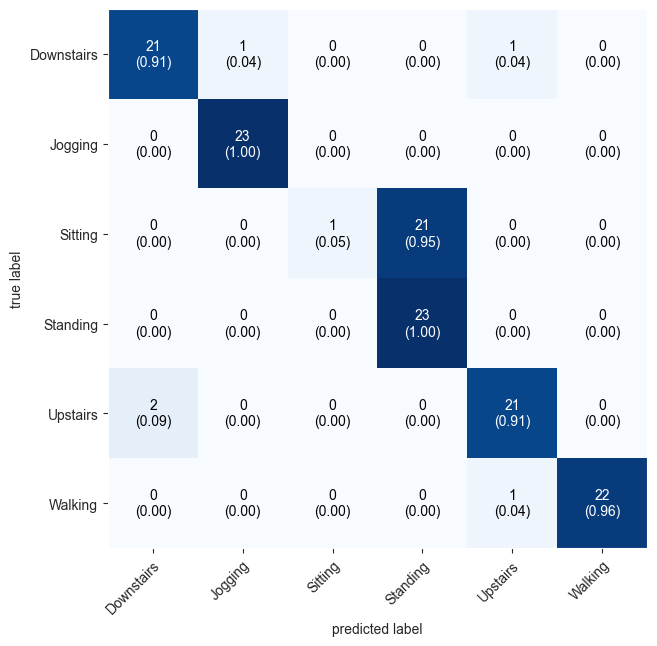

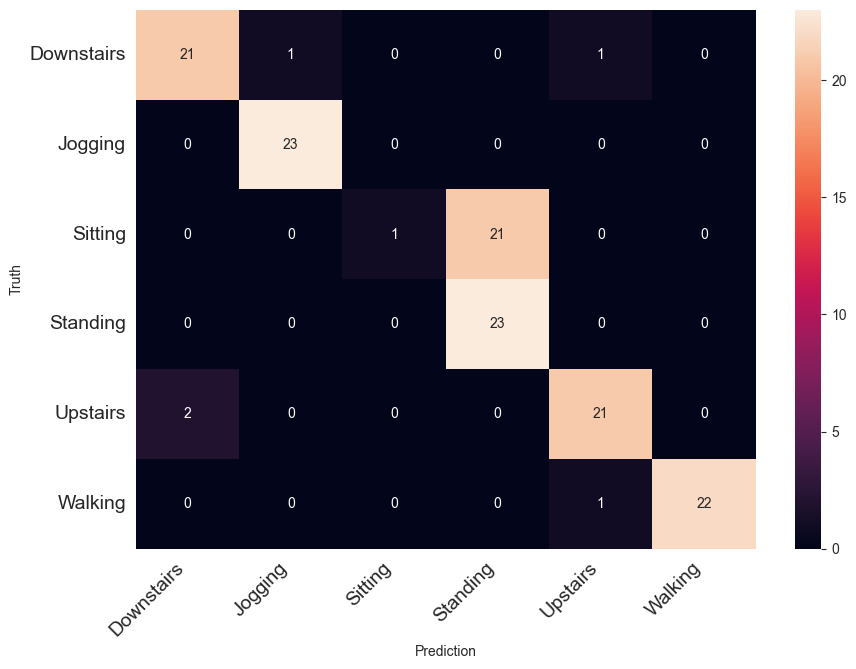

In [128]:

truth = ["Jogging", "Sitting", "Standing", "Stairs", "Walking"]
prediction = ["Jogging", "Sitting", "Standing", "Stairs", "Walking"]

y_pred = np.argmax(model.predict(X_train), axis=-1)
mat = confusion_matrix(y_train, y_pred)
plot_confusion_matrix(conf_mat=mat, class_names=label.classes_, show_normed=True, figsize=(7, 7))
plt.show()  # You also need to add this line to display the plot

print_confusion_matrix(mat, label.classes_)